# CMIP6 Landmask Model

**Following steps are included in this script:**

1. Load netCDF files
2. Create landmask for each model using the land variable lai 
3. Save as netcdf files

In [1]:
# ========== Packages ==========
import xarray as xr
import pandas as pd
import numpy as np
import dask
import os

### Functions

In [2]:
def save_file(save_file, folder, save_var=True):
    """
    Save files as netCDF.

    Args:
        savefile (dict or dataset): Dictionary of xarray datasets or dataset.
        folder (string): Name of folder data is saved in.
        save_var (boolean): If True, data is saved separately for each variable. If false, one file is saved with all variables.
        

    Returns:
        nc_out: Path were data is saved in.
    """
    
    if save_var:
        for key, ds in save_file.items():
            for var in ds:
                # Variable to keep
                variable_to_keep = var
                dimensions_to_keep = {'time', 'lat', 'lon'}
                coordinates_to_keep = {'time', 'lat', 'lon'}

                if any('depth' in ds[var].dims for var in ds.variables):
                    dimensions_to_keep.add('depth')
                    coordinates_to_keep.add('depth')

                # Create a new dataset with only the desired variable
                ds_var = ds[[variable_to_keep]]

                # Keep only the desired dimensions
                ds_var = ds_var.isel({dim: slice(None) for dim in dimensions_to_keep.intersection(ds_var.dims)})

                # Set the desired coordinates
                coords_to_set = set(ds_var.variables).intersection(coordinates_to_keep)
                ds_var = ds_var.set_coords(list(coords_to_set))

                savepath = f'../../data/CMIP6/landmask/raw/land_var/'
                filename = f'CMIP.{ds_var.source_id}.landmask.nc'
                nc_out = os.path.join(savepath, filename)
                os.makedirs(savepath, exist_ok=True) 
                if os.path.exists(nc_out):
                        inp = input(f"Delete old file {filename} (y/n):")
                        if inp.lower() in ["y"]:
                            os.remove(nc_out)
                            print(f"File  with path: {nc_out} removed")
                        else:
                            filename = "temp_file.nc"
                            nc_out = os.path.join(savepath, filename)
                            print(f"Filename change to {filename}")

                # Save to netcdf file
                with dask.config.set(scheduler='threads'):
                    ds_var.to_netcdf(nc_out)
                    print(f"File with path: {nc_out} saved")
       
    else:
        for key in save_file.keys():
            ds_in = save_file[key]
            filename = f'CMIP.{ds_in.source_id}.{ds_in.experiment_id}.nc'
            savepath = f'../../data/CMIP6/landmask/raw/land_var/'
            nc_out = os.path.join(savepath, filename)
            os.makedirs(savepath, exist_ok=True) 
            if os.path.exists(nc_out):
                inp = input(f"Delete old file {filename} (y/n):")
                if inp.lower() in ["y"]:
                    os.remove(nc_out)
                    print(f"File  with path: {nc_out} removed")
                else:
                    filename = "temp_file.nc"
                    nc_out = os.path.join(savepath, filename)
                    print(f"Filename change to {filename}")

            # Save to netcdf file
            with dask.config.set(scheduler='threads'):
                ds_in.to_netcdf(nc_out)

    return nc_out

### 1. Load netCDF files

In [174]:
# ========= Define period, models and path ==============
variable='gpp'
experiment_id = 'historical'
source_id = ['CESM2-WACCM'] # 'TaiESM1', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CanESM5', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'UKESM1-0-LL', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'NorESM2-MM'], 
savepath = f'../../data/CMIP6/{experiment_id}/raw/{variable}'

# ========= Use Dask to parallelize computations ==========
dask.config.set(scheduler='processes')

# ========= Create a helper function to open the dataset ========
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

# ========= Create dictionary using a dictionary comprehension and Dask =======
ds_dict, = dask.compute({model: open_dataset(os.path.join(savepath, f'CMIP.{model}.{experiment_id}.{variable}.nc'))
                        for model in source_id})

In [175]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]]

['CESM2-WACCM']


<xarray.Dataset>
Dimensions:  (time: 1980, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    gpp      (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    case_id:                 4
    cesm_casename:           b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001
    contact:                 cesm_cmip6@ucar.edu
    creation_date:           2019-01-30T21:05:54Z
    ...                      ...
    branch_time_in_parent:   20075.0
    branch_time_in_child:    674885.0
    branch_method:           standard
    intake_esm_varname:      mrsol
    intake_esm_dataset_key:  CMIP.CESM2-WACCM.historical.Emon.gn
    log:                     Time coordinate changed to format cftime.Datetim...

### 2. Create Landmask

In [176]:
lai = (ds_dict[list(ds_dict.keys())[0]].gpp).mean('time')

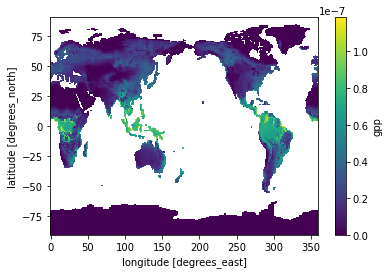

In [177]:
lai.plot()

In [133]:
# print unique values
print(f"Unique values:", np.unique(lai.values))

Unique values: [0.0000000e+00 4.0811389e-25 3.5362451e-23 ... 1.1577442e-07 1.1613750e-07
 1.1642324e-07]


In [134]:
# set all numbers below or equal to zero to nan
landmask_lai = lai.where(lai >= 0)

In [135]:
# set all numbers above zero to 1
landmask_lai = landmask_lai.where(landmask_lai.isnull(), 1)

In [136]:
# print unique values
print(f"Unique values:", np.unique(landmask_lai.values))

Unique values: [1.]


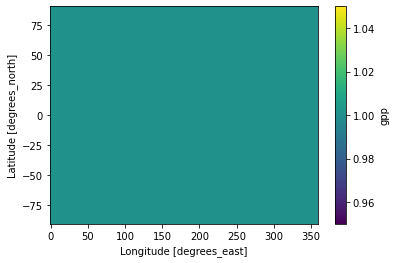

In [137]:
landmask_lai.plot()

### 4. Save and replace netcdf files

In [127]:
folder='raw'

In [128]:
# =========== Store file and remove any former one ==========
nc_out = save_file(ds_dict, folder=folder)

File with path: ../../data/CMIP6/landmask/raw/land_var/CMIP.CESM2-FV2.landmask.nc saved


In [ ]:
# =========== Check stored file ==============
xr.open_dataset(nc_out)